In [1]:
import torch,math,os,torchvision,random, einops
import glob
from torch import nn
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torchvision.transforms as tfms
import torchvision.transforms.functional as tfF
from torchvision.utils import *
from argparse import Namespace

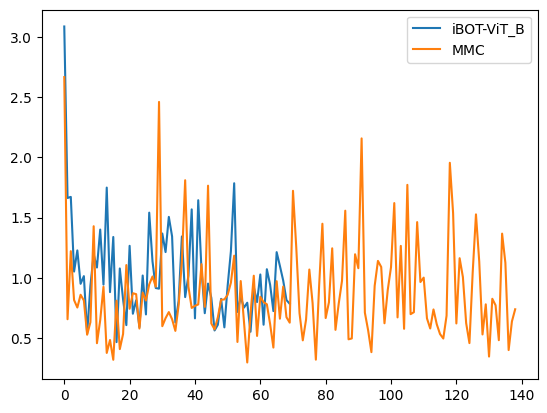

In [9]:
for file in ["../outputs/models/iBOT-ViT_B/eval_seg/finetine-coco/linear_vit_base_coco_log.txt","../outputs/models/MMC/eval_seg/finetine-coco1/linear_vit_base_coco_log.txt"]:
    model_name = file.split("/")[-4]
    with open(file) as f:
        lines = f.readlines()
        losses = []
        for line in lines:
            if "Loss:" in line:
                loss = float(line.split("||")[2][6:])
                losses.append(loss)
        x = np.array(losses)
        # define the window size for the moving average filter
        window_size = 100

        # apply the moving average filter to smooth the values in 'x'
        smoothed_x = np.convolve(x, np.ones(window_size)/window_size, mode='valid')
        plt.plot(x[::100], label=model_name)
plt.legend()

In [67]:
import glob
data=[]
for file in glob.glob("../outputs/models/*/eval/fewshot/log.txt"):
    for row in open(file).readlines():
        if not 'ominiglot' in row: continue
        rrow = eval(row)
        model_name = file.split("/")[-4]
        rrow['model']=model_name
        data.append(rrow)
df=pd.DataFrame(data)
df

precision@0.1  recall@0.1  precision@0.2  recall@0.2  precision@0.3  \
0            0.2         1.0            0.2         1.0            0.2   
1            0.2         1.0            0.2         1.0            0.2   
2            0.2         1.0            0.2         1.0            0.2   
3            0.2         1.0            0.2         1.0            0.2   
4            0.2         1.0            0.2         1.0            0.2   
5            0.2         1.0            0.2         1.0            0.2   
6            0.2         1.0            0.2         1.0            0.2   
7            0.2         1.0            0.2         1.0            0.2   

   recall@0.3  precision@0.4  recall@0.4  precision@0.5  recall@0.5  ...  \
0         1.0       0.200000    1.000000       0.200000    1.000000  ...   
1         1.0       0.200000    1.000000       0.200000    1.000000  ...   
2         1.0       0.199972    0.999667       0.202225    0.989667  ...   
3         1.0       0.200000    1.000000       0.200913    0.997333  ...   
4         1.0       0.200000    1.000000       0.200000    1.000000  ...   
5         1.0       0.200000    1.000000       0.200879    0.996000  ...   
6         1.0       0.200000    1.000000       0.200000    1.000000  ...   
7         1.0       0.200000    1.000000       0.200111    1.000000  ...   

   recall@0.9  accuracy          job_name      arch  head_type  \
0    1.000000  0.443333  eval_fewshot_cls  vit_base          0   
1    0.788667  0.591000  eval_fewshot_cls  vit_base          0   
2    0.289000  0.585000  eval_fewshot_cls  vit_base          0   
3    0.318333  0.540000  eval_fewshot_cls  vit_base          0   
4    1.000000  0.533333  eval_fewshot_cls  vit_base          0   
5    0.349000  0.555000  eval_fewshot_cls  vit_base          0   
6    0.664667  0.511333  eval_fewshot_cls  vit_base          0   
7    0.621000  0.590000  eval_fewshot_cls  vit_base          0   

                           pretrained_weights   data_set  data_location  \
0      outputs/models/mae-base/checkpoint.pth  ominiglot        ../data   
1           outputs/models/SiT/checkpoint.pth  ominiglot        ../data   
2    outputs/models/iBOT-ViT_B/checkpoint.pth  ominiglot        ../data   
3  outputs/models/MC_SSL-ViT_B/checkpoint.pth  ominiglot        ../data   
4     outputs/models/MSN-ViT_B/checkpoint.pth  ominiglot        ../data   
5    outputs/models/DINO-ViT_B/checkpoint.pth  ominiglot        ../data   
6           outputs/models/MMC/checkpoint.pth  ominiglot        ../data   
7     outputs/models/sit-ViT_B/checkpoint.pth  ominiglot        ../data   

   k_shot         model  
0       1      mae-base  
1       1           SiT  
2       1    iBOT-ViT_B  
3       1  MC_SSL-ViT_B  
4       1     MSN-ViT_B  
5       1    DINO-ViT_B  
6       1           MMC  
7       1     sit-ViT_B  

[8 rows x 27 columns]

In [68]:
df_f1 = pd.DataFrame()

for i in range(1,10):
    precision = df[f"precision@0.{i}"]
    recall = df[f"recall@0.{i}"]
    f1 = 2*precision*recall/(precision+recall)
    df_f1[f"f1@0.{i}"] = f1
df_f1['model'] = df['model']

df_f1['max_f1'] = df_f1.max(axis=1)

/tmp/ipykernel_29156/2406852179.py:10: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df_f1['max_f1'] = df_f1.max(axis=1)


In [69]:
df.pivot_table(index='model',columns=['data_set','k_shot'],values='accuracy')

data_set     ominiglot
k_shot               1
model                 
DINO-ViT_B    0.555000
MC_SSL-ViT_B  0.540000
MMC           0.511333
MSN-ViT_B     0.533333
SiT           0.591000
iBOT-ViT_B    0.585000
mae-base      0.443333
sit-ViT_B     0.590000

In [167]:
data = []
for file in glob.glob("../outputs/models/*/eval_seg/linear-coco/*/linear_vit_base_coco_log.txt"):
    model_name = file.split("/")[3]
    for row in open(file, "r").readlines():
        if "mIoU" in row:
            index = row.find("mIoU: ")
            row_dict={
                "model": model_name,
                "mIoU": float(row[index+6:])
            }
            data.append(row_dict)
df=pd.DataFrame(data)

In [168]:
df.groupby('model').mean().round(1)

mIoU
model      
MMC    44.1

In [139]:
pd.concat([df,df_f1],1).to_csv('fewshot_cls.csv')

/tmp/ipykernel_8951/1923204960.py:1: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  pd.concat([df,df_f1],1).to_csv('fewshot_cls.csv')


In [10]:
sns.set_style("darkgrid")

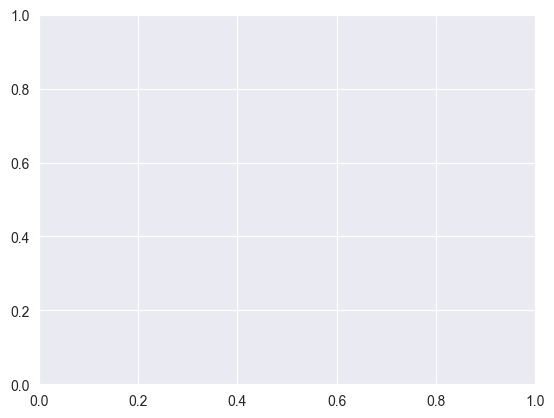

In [8]:
# Get the current Axes instance
ax = plt.gca()
# Get the current color cycle
color_cycle = [i for i,_ in zip(ax._get_lines.prop_cycler,range(10))]

In [5]:
i

{'color': '#1f77b4'}

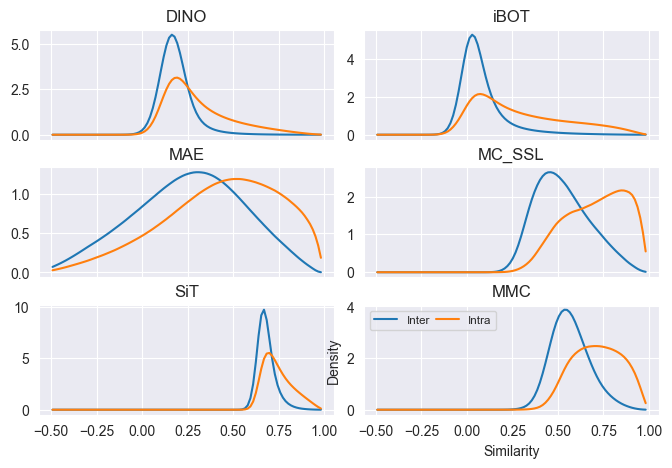

In [13]:
import glob
fig,axes = plt.subplots(3,2,figsize=(8,5))
axes = axes.flatten()
fig.subplots_adjust(wspace=0.10, hspace=0.25) 
bin_edges = np.linspace(-0.5,0.99,101)
sim = (bin_edges[1:] + bin_edges[:-1])/2

for i,file in enumerate(glob.glob("../outputs/pics/similarity/*.npy")):
    ax = axes[i]
    model = file.split("/")[-1].split(".")[0]
    sim_dict = np.load(file,allow_pickle=True).item()
    ax.plot(sim,sim_dict['inter_density_class'],label='Inter')
    ax.plot(sim,sim_dict['intra_density_class'],label='Intra')
    if i<4:
        ax.set_xticklabels([])
        # ax.get_xaxis().set_visible (False)
    ax.set_title(model)
    
ax.set_xlabel("Similarity")
ax.set_ylabel("Density")

ax.legend(fontsize='small',ncol=2,columnspacing=0.5)

plt.savefig("../outputs/pics/similarity/comparison.pdf")

In [4]:
import glob
data = []
bin_edges = np.linspace(-0.5,0.99,101)
sim = (bin_edges[1:] + bin_edges[:-1])/2
for file in glob.glob("../outputs/pics/similarity/*.npy"):
    model = file.split("/")[-1].split(".")[0]
    sim_dict = np.load(file,allow_pickle=True).item()
    intra_mean = np.mean(sim_dict["intra_density_class"]*sim)
    inter_mean = np.mean(sim_dict["inter_density_class"]*sim)
    data.append({
        'model':model,
        'intra_mean':intra_mean,
        'inter_mean':inter_mean,
    })
df=pd.DataFrame(data)

In [9]:
df.round(2).T

0     1     2       3     4     5
model       DINO  iBOT   MAE  MC_SSL   SiT   MMC
intra_mean   0.2  0.19  0.29    0.47   0.5  0.48
inter_mean  0.12  0.05  0.17    0.35  0.46  0.38

In [144]:
data = []
for file in glob.glob("../outputs/models/*/eval_zero_shot/class-*-bn.txt"):
    model_name = file.split("/")[-3]
    threshold = file.split("/")[-1].split("-")[1]
    row = eval(open(file).readlines()[-1])
    row.update({
        "model_name": model_name,
        "threshold": threshold
    })
    data.append(row)
df = pd.DataFrame(data)

In [154]:
df_table=df.pivot_table('0/mIoU',index="model_name",columns="threshold")
df_max=df_table.max(1)
pd.concat((df_table[['0.1', '0.2', '0.3', '0.4']],df_max),axis=1).sort_values(by=0,ascending=False)*100

0.1        0.2        0.3        0.4          0
model_name                                                         
ours_450      34.946366  38.231911  39.023462  37.405202  39.023462
sit-ViT_B     34.912180  38.560591  38.967159        NaN  38.967159
MMC           34.583488  37.637821  38.435633  37.855579  38.435633
ours_iBOT2    33.689454  36.827974  37.453705  35.759551  37.453705
iBOT-ViT_B    33.473906  36.201428  36.241233  34.127575  36.241233
SiT           32.908950  35.324597  34.679266  31.572668  35.324597
DINO-ViT_B    33.293680  35.119590  32.968318  28.157776  35.119590
MC_SSL-ViT_B  31.862449  34.211217  34.993892  35.098061  35.098061
MSN-ViT_B     32.719587  34.445801  31.588284  25.904823  34.445801
mae-base      28.625842  30.108465  26.031382  18.469602  30.108465
RAND          16.832723  16.633079  16.210434  15.539755  16.832723

In [56]:
import glob
data = []
for file in glob.glob("../outputs/models/*/eval/fewshot/log.txt"):
    for row in open(file).readlines():
        rrow = eval(row)
        rrow["model"] = file.split("/")[-4]
        data.append(rrow)
df = pd.DataFrame(data)
df

precision@0.1  recall@0.1  precision@0.2  recall@0.2  precision@0.3  \
0        0.199986    0.999333       0.200027    0.998667       0.200135   
1        0.200000    1.000000       0.200008    1.000000       0.200008   
2        0.200000    1.000000       0.200008    1.000000       0.200008   
3        0.200097    0.999800       0.200291    0.999200       0.200920   
4        1.000000    1.000000       1.000000    1.000000       1.000000   
..            ...         ...            ...         ...            ...   
74       0.200014    1.000000       0.200352    1.000000       0.202032   
75       0.199987    0.999667       0.200258    0.999000       0.201438   
76       0.200000    1.000000       0.200000    1.000000       0.200000   
77       0.200000    1.000000       0.200067    1.000000       0.203418   
78       0.200000    1.000000       0.200000    1.000000       0.200000   

    recall@0.3  precision@0.4  recall@0.4  precision@0.5  recall@0.5  ...  \
0     0.995000       0.200372    0.989333       0.201355    0.978667  ...   
1     0.999800       0.200065    0.999400       0.200252    0.998800  ...   
2     0.999800       0.200065    0.999400       0.200252    0.998800  ...   
3     0.997600       0.202576    0.994400       0.204833    0.983400  ...   
4     0.999000       1.000000    0.993000       1.000000    0.981000  ...   
..         ...            ...         ...            ...         ...  ...   
74    0.999667       0.208530    0.997667       0.222757    0.989000  ...   
75    0.994000       0.203207    0.980000       0.207011    0.947333  ...   
76    1.000000       0.200000    1.000000       0.200000    1.000000  ...   
77    0.995000       0.250251    0.933000       0.451365    0.722000  ...   
78    1.000000       0.200000    1.000000       0.200111    1.000000  ...   

    recall@0.9  accuracy          job_name      arch  head_type  \
0     0.560667  0.270667  eval_fewshot_cls  vit_base          0   
1     0.721800  0.244400  eval_fewshot_cls  vit_base          0   
2     0.721800  0.244400  eval_fewshot_cls  vit_base          0   
3     0.548800  0.272000  eval_fewshot_cls  vit_base          0   
4     0.567000  1.000000  eval_fewshot_cls  vit_base          0   
..         ...       ...               ...       ...        ...   
74    0.193667  0.648333  eval_fewshot_cls  vit_base          0   
75    0.166000  0.280667  eval_fewshot_cls  vit_base          0   
76    0.664667  0.511333  eval_fewshot_cls  vit_base          0   
77    0.004333  0.686000  eval_fewshot_cls  vit_base          0   
78    0.621000  0.590000  eval_fewshot_cls  vit_base          0   

                         pretrained_weights   data_set  \
0    outputs/models/mae-base/checkpoint.pth     Folder   
1    outputs/models/mae-base/checkpoint.pth       Pets   
2    outputs/models/mae-base/checkpoint.pth       Pets   
3    outputs/models/mae-base/checkpoint.pth    CIFAR10   
4    outputs/models/mae-base/checkpoint.pth    CIFAR10   
..                                      ...        ...   
74        outputs/models/MMC/checkpoint.pth    Flowers   
75        outputs/models/MMC/checkpoint.pth   Aircraft   
76        outputs/models/MMC/checkpoint.pth  ominiglot   
77  outputs/models/sit-ViT_B/checkpoint.pth     Folder   
78  outputs/models/sit-ViT_B/checkpoint.pth  ominiglot   

                data_location  k_shot      model  
0   ../data/miniImagenet/test       1   mae-base  
1                     ../data       1   mae-base  
2                     ../data       1   mae-base  
3                     ../data       1   mae-base  
4                     ../data       1   mae-base  
..                        ...     ...        ...  
74                    ../data       1        MMC  
75                    ../data       1        MMC  
76                    ../data       1        MMC  
77  ../data/miniImagenet/test       1  sit-ViT_B  
78                    ../data       1  sit-ViT_B  

[79 rows x 27 columns]

In [57]:
for i in range(1,10):
    precision = df[f"precision@0.{i}"]
    recall = df[f"recall@0.{i}"]
    f1 = 2*(precision*recall)/(precision+recall)
    df[f"f1@0.{i}"] = f1

In [58]:
df1 = df.drop_duplicates()
(df1.pivot("model",["data_set"],["accuracy"])*100).round(1)

/tmp/ipykernel_29156/1707208138.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  (df1.pivot("model",["data_set"],["accuracy"])*100).round(1)


ValueError: Index contains duplicate entries, cannot reshape

In [59]:
df1['f1']=df1[[f"f1@0.{i}" for i in range(1,10)]].max(1)
(df1.pivot("model",["data_set"],["accuracy","f1"])*100).round(1).loc[["mae-base","DINO-ViT_B","iBOT-ViT_B","MC_SSL-ViT_B","SiT","sit_iBOT-ViT_B"]]

/tmp/ipykernel_29156/2893813969.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['f1']=df1[[f"f1@0.{i}" for i in range(1,10)]].max(1)
/tmp/ipykernel_29156/2893813969.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  (df1.pivot("model",["data_set"],["accuracy","f1"])*100).round(1).loc[["mae-base","DINO-ViT_B","iBOT-ViT_B","MC_SSL-ViT_B","SiT","sit_iBOT-ViT_B"]]


ValueError: Index contains duplicate entries, cannot reshape

In [60]:
data= []
import glob
for file in glob.glob("../outputs/models/*/eval/*/log.txt"):
    try:
        metric,head,data_set = file.split("/")[-2].split("-")
        model = file.split("/")[-4]
        lines = open(file).readlines()
        if metric == "knn":
            row_dict = eval(lines[0])
        else:
            for line in lines[-1::-1]:
                if "test/acc1" in line:
                    row_dict = eval(line)
                    break
        
        row_dict.update({"model":model,"metric":metric,"head":head,"file":file,"data_set":data_set})
        if metric == "knn":
            row_dict['acc'] = row_dict['10/acc1']
        else:
            row_dict['acc'] = row_dict['test/acc1']
        data.append(row_dict)
    except Exception as e:
        print(file,e)
df = pd.DataFrame(data)

../outputs/models/mae-base/eval/finetune-CIFAR10/log.txt not enough values to unpack (expected 3, got 2)
../outputs/models/mae-base/eval/knn_bn-1-Flowers/log.txt 'test/acc1'
../outputs/models/mae-base/eval/linprob-1K/log.txt not enough values to unpack (expected 3, got 2)
../outputs/models/mae-base/eval/ImageRetieval/log.txt not enough values to unpack (expected 3, got 1)
../outputs/models/mae-base/eval/linprob-Flowers/log.txt not enough values to unpack (expected 3, got 2)
../outputs/models/mae-base/eval/finetune-Flowers/log.txt not enough values to unpack (expected 3, got 2)
../outputs/models/mae-base/eval/knn_bn-1-100/log.txt 'test/acc1'
../outputs/models/mae-base/eval/knn_bn-1-Pets/log.txt 'test/acc1'
../outputs/models/mae-base/eval/fewshot/log.txt not enough values to unpack (expected 3, got 1)
../outputs/models/mae-base/eval/finetune-Pets/log.txt not enough values to unpack (expected 3, got 2)
../outputs/models/mae-base/eval/finetune-1K/log.txt not enough values to unpack (expect

In [61]:
df.pivot_table(index=['metric','model'],columns=['head','data_set'],values='acc').round(1)

head                        0                                 1                \
data_set                  100    1K CIFAR10 Flowers  Pets   100    1K CIFAR10   
metric   model                                                                  
finetune DINO-ViT_B       NaN   NaN     NaN     NaN   NaN   NaN   NaN     NaN   
         MC_SSL-ViT_B     NaN   NaN     NaN     NaN   NaN   NaN   NaN     NaN   
         MMC              NaN   NaN     NaN     NaN   NaN   NaN   NaN     NaN   
         MMC_sit          NaN   NaN     NaN     NaN   NaN   NaN   NaN     NaN   
         MSN-ViT_B        NaN   NaN     NaN     NaN   NaN   NaN   NaN     NaN   
         iBOT-ViT_B       NaN   NaN     NaN     NaN   NaN   NaN   NaN     NaN   
         mae-base         NaN   NaN     NaN     NaN   NaN   NaN   NaN     NaN   
         ours_450         NaN   NaN     NaN     NaN   NaN   NaN   NaN     NaN   
         ours_iBOT2       NaN   NaN     NaN     NaN   NaN   NaN   NaN     NaN   
         sit-ViT_B        NaN   NaN     NaN    53.4  90.5   NaN   NaN     NaN   
knn      DINO-ViT_B      91.5   NaN    96.1    85.8  90.4  75.6   NaN    87.2   
         MC_SSL-ViT_B    89.0   NaN    90.7    77.2  87.2  83.4   NaN    90.3   
         MMC             83.7   NaN    94.3    60.6  72.9  87.8   NaN    96.3   
         MSN-ViT_B       89.4  89.4    94.6     NaN   NaN  82.4   NaN    91.4   
         SiT             87.6   NaN     NaN     NaN   NaN  76.4   NaN    91.9   
         iBOT-ViT_B      92.1   NaN    96.2    84.5  89.1  75.2   NaN    90.4   
         mae-base        47.0  26.8    52.0    18.7  21.0  35.3  17.9    52.1   
         ours_450        87.5   NaN    92.8    68.5  78.2  88.3   NaN    93.4   
         ours_iBOT2      77.5   NaN    91.3    56.0  58.5   NaN   NaN    92.8   
         sit-ViT_B       89.9   NaN    96.4    78.2  89.9  90.0   NaN    96.7   
knn_bn   mae-base         NaN   NaN     NaN     NaN   NaN  20.4   NaN    38.5   
linprob  DINO-ViT_B       NaN  77.4     NaN     NaN   NaN   NaN  68.8     NaN   
         MC_SSL-ViT_B     NaN  74.2     NaN     NaN   NaN   NaN  70.1     NaN   
         MMC              NaN  72.1     NaN     NaN   NaN   NaN  74.1     NaN   
         MMC_sit          NaN   NaN     NaN     NaN   NaN   NaN   NaN     NaN   
         MSN-ViT_B        NaN   NaN     NaN     NaN   NaN   NaN   NaN     NaN   
         SiT              NaN  75.9     NaN     NaN   NaN   NaN  69.2     NaN   
         iBOT-ViT_B      93.3  78.4     NaN     NaN   NaN   NaN  68.1     NaN   
         mae-base         NaN  58.0     NaN     NaN   NaN   NaN  58.7     NaN   
         sit-ViT_B        NaN  75.5     NaN     NaN   NaN   NaN  75.6     NaN   
         sit_iBOT-ViT_B   NaN  72.1     NaN     NaN   NaN   NaN  74.1     NaN   

head                                      2                               \
data_set                Flowers  Pets   100   10P    1K Aircraft CIFAR10   
metric   model                                                             
finetune DINO-ViT_B         NaN   NaN   NaN   NaN   NaN     86.6    98.7   
         MC_SSL-ViT_B       NaN   NaN   NaN   NaN   NaN     80.4    99.1   
         MMC                NaN   NaN  94.7  72.8  83.6     85.6    98.9   
         MMC_sit            NaN   NaN   NaN   NaN   NaN     85.3    98.8   
         MSN-ViT_B          NaN   NaN   NaN   NaN   NaN     82.1    98.9   
         iBOT-ViT_B         NaN   NaN  89.2  75.3  84.0     88.5    98.8   
         mae-base           NaN   NaN   NaN   NaN   NaN     90.8    98.9   
         ours_450           NaN   NaN   NaN  73.9  82.7      NaN     NaN   
         ours_iBOT2         NaN   NaN   NaN  72.7  83.1      NaN     NaN   
         sit-ViT_B          NaN   NaN  94.1  75.0  83.0     85.3    99.1   
knn      DINO-ViT_B        71.6  70.8   NaN   NaN   NaN      NaN     NaN   
         MC_SSL-ViT_B      54.6  72.5  87.8   NaN   NaN      NaN    91.0   
         MMC               62.8  75.9   NaN   NaN   NaN      NaN     NaN   
         MSN-ViT_B          N

In [54]:
df = pd.read_csv('../transfer_1K.csv',index_col=0)
df

IN1K  Aircraft  CIFAR10  CIFAR100  Cars  Flowers  Pets
DINO    82.8      86.6     98.7      88.6  93.8     97.1  93.3
MC-SSL  84.0      88.4     99.1      91.0  93.5     98.9  93.7
MSN     83.4      82.1     98.9      89.3  92.3     96.3  93.2
iBOT    84.0      88.5     98.8      89.0  94.0     97.5  93.4
MAE     83.4      90.8     98.9      89.4  94.5     96.6  93.7
MMC     83.6      86.3     98.9      90.3  93.9     97.5  93.5

In [15]:
vmax=df.max()
vmin=df.min() 
ndf = (df - vmin) / (vmax - vmin) + 0.15
ndf

IN1K  Aircraft  CIFAR10  CIFAR100     Cars  Flowers  Pets
MMC     0.816667  0.717308     0.65  0.858333  0.96250   1.1500  0.75
DINO    0.150000  0.746154     0.15  0.150000  0.93125   0.9000  0.35
MC-SSL  1.150000  0.150000     1.15  1.150000  0.15000   0.1500  1.15
MSN     0.650000  0.313462     0.65  0.441667  0.46250   0.4000  0.15
iBOT    1.150000  0.928846     0.40  0.316667  0.99375   1.1500  0.55
MAE     0.650000  1.150000     0.65  0.483333  1.15000   0.5875  1.15

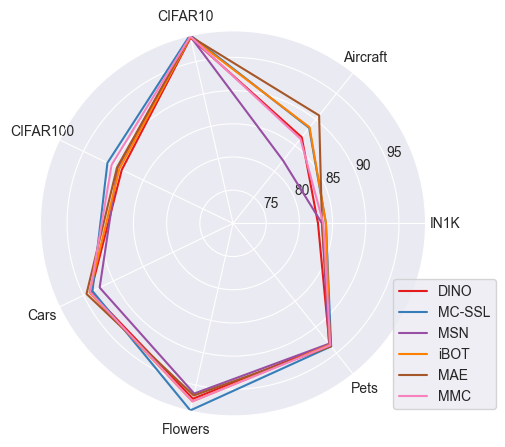

In [55]:
# drawing a radial plot of models on different dtasets

import numpy as np
import matplotlib.pyplot as plt

# create some data
theta = np.linspace(0, 2*np.pi, len(df.columns), endpoint=False)
theta = np.array(theta.tolist() + [theta[0]])
# plot the data as a radial plot
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111, polar=True)

# loop over the rows of the DataFrame and plot each row with a different color
for i,(model,row) in enumerate(df.iterrows()):
    row = row.values
    color = plt.cm.Set1(i / float(len(df)))
    # for t,y,v in zip(theta,row,nrow):
    #     n = 0.05+ np.random.rand()/10
    #     ax.text(t+n, v, f"{y:.1f}" , ha="center",bbox=dict(facecolor='white', edgecolor='none', alpha=0.7))
    ax.plot(theta, row.tolist()+[row[0]], color=color,label=model)
    # break
ax.set_ylim(70,99)
# ax.set_yticklabels([])
ax.set_thetagrids(theta[:-1] * 180/np.pi, df.columns)
# ax.set_title('Radial Plot')
plt.legend(loc='lower right', bbox_to_anchor=(1.2, 0.),ncol=1)
plt.savefig('radial_plot.pdf',dpi=300,bbox_inches='tight')

In [23]:
theta.shape

(7,)